In [10]:
from ocpy import ddp, symutils
from ocpy.ddp import DDP
from ocpy.ocp import OCP
import numpy as np
import sympy as sym
from sympy import sin, cos, tan, exp, log, ln, sinh, cosh, tanh, diff, sqrt


In [11]:
n_x = 4
n_u = 1
sim_name = 'cartpole'
ocp = OCP(n_x, n_u, sim_name)

t = ocp.get_t()
x = ocp.get_x()
u = ocp.get_u()

In [12]:
m_c, m_p, l, g, u_min, u_max, u_eps = ocp.define_scalar_constants(
         [('m_c', 2), ('m_p', 0.1), ('l', 0.5), ('g', 9.80665), 
          ('u_min', -20),  ('u_max', 20), ('u_eps', 0.001)]
          )
q = ocp.define_vector_constant('q', [2.5, 10, 0.01, 0.01])
r = ocp.define_vector_constant('r', [1])
q_terminal = ocp.define_vector_constant('q_f', [2.5, 10, 0.01, 0.01])
x_ref = ocp.define_vector_constant('x_ref', [0, np.pi, 0, 0])

Q = sym.diag(*q)
Qf = sym.diag(*q_terminal)
R = sym.diag(*r)

In [13]:
f = ocp.get_f_empty()
f[0] = x[2]
f[1] = x[3]
f[2] = (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1]) )
f[3] = (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) 
        - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))

u_barrier = sum(-ln(u[i] - u_min) - ln(u_max - u[i]) for i in range(n_u)) * 1e-3

l = (x - x_ref).T * Q * (x - x_ref) + u.T * R * u # + sympy.Matrix([u_barrier])
lf = (x - x_ref).T * Qf * (x - x_ref) * 10

display(f)
display(l)

Matrix([
[                                                                                                        x[2]],
[                                                                                                        x[3]],
[                                   (m_p*(g*cos(x[1]) + l*x[1]**2)*sin(x[1]) + u[0])/(m_c + m_p*sin(x[1])**2)],
[(-g*(m_c + m_p)*sin(x[1]) - l*m_p*x[1]**2*sin(x[1])*cos(x[1]) - u[0]*cos(x[1]))/(l*(m_c + m_p*sin(x[1])**2))]])

Matrix([[q[0]*(x[0] - x_ref[0])**2 + q[1]*(x[1] - x_ref[1])**2 + q[2]*(x[2] - x_ref[2])**2 + q[3]*(x[3] - x_ref[3])**2 + r[0]*u[0]**2]])

In [14]:
T = 5.0
N = 200
t0 = 0.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])
us_guess = np.zeros((N, n_u))

ocp.define(f, l, lf, T, N, t0, x0, us_guess, True, False)


In [15]:
solver = DDP(ocp)

iter: 0
-954.6388203845879
iter: 1
-27115.451214196113
iter: 2
-1893.7678350039505
iter: 3
-2585.1901257465743
iter: 4
-827.89810965155
iter: 5
-228.58231270345723
iter: 6
-59.25639578673923
iter: 7
-147.6431871380524
iter: 8
-35.071958161772926
iter: 9
-17748.738048584444
iter: 10
-2701.7087849575846
iter: 11
-128.35101361059344
iter: 12
-19.883429639585568
iter: 13
-9.080071333955761
iter: 14
-5.324166551069713
iter: 15
-3.3900461087893894
iter: 16
-3.4442076496770824
iter: 17
-5.807635934448388
iter: 18
-10.107354733031805
iter: 19
-4.662610421714969
iter: 20
-8.84103423736964
iter: 21
-3.8598414816317583
iter: 22
-6.702310405573009
iter: 23
-2.5765792372791605
iter: 24
-2.94143737722606
iter: 25
-2.350070360547625
iter: 26
-2.324014327611323
iter: 27
-2.3831079605860968
iter: 28
-2.4855111209932463
iter: 29
-4.096478567936801
iter: 30
-11.002243789586952
iter: 31
-2.152562077309513
iter: 32
-2.2136398126257535
iter: 33
-3.4796910846667095
iter: 34
-8.676454162942948
iter: 35
-1.904

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Graphs are saved at /home/ohtsukalab/src/ocpy/log/cartpole/result.pdf


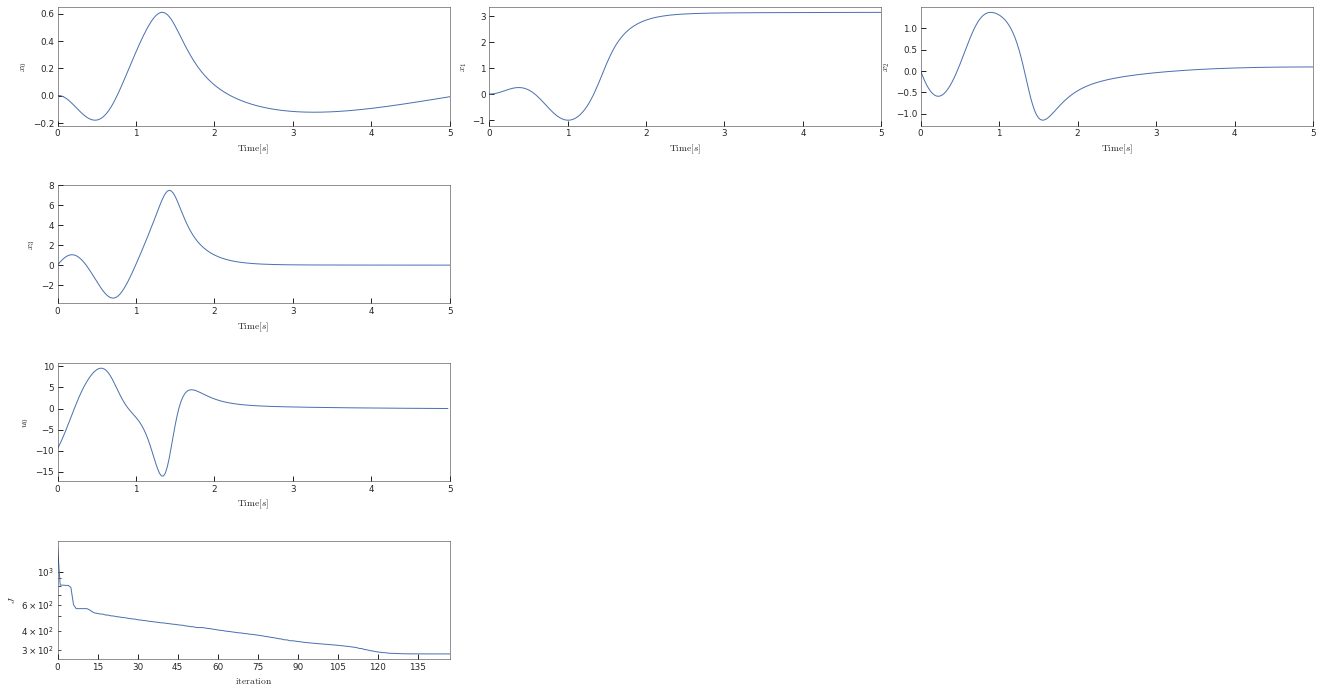

In [16]:
ts, xs, us, Js = solver.solve(t0, x0, us_guess, max_iter=200, log=True)

Animation was saved at /home/ohtsukalab/src/ocpy/log/cartpole .


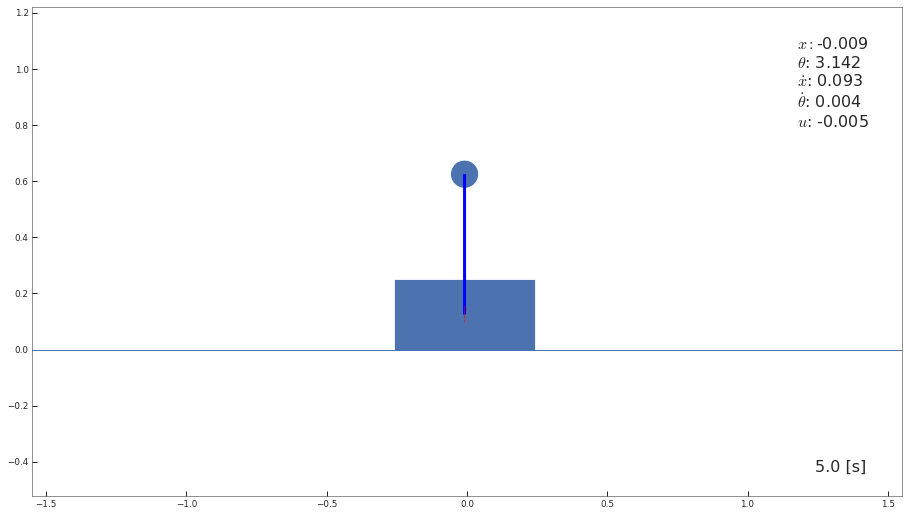

In [19]:
%matplotlib inline
from ocpy.animator import CartPoleAnimator
animator = CartPoleAnimator(solver.log_directory(), sim_name)
animator.generate_animation(True)
